In [ ]:
# standard libraries
import numpy as np
import matplotlib.pyplot as plt

# additional libraries
import pandas as pd
import seaborn as sns
from pandas import read_pickle
from tqdm import tqdm

# Scikit-learn 
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
from sklearn.preprocessing import LabelEncoder

# Imbalanced-learn
from imblearn.over_sampling import RandomOverSampler

# TensorFlow / Keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from keras.models import Model
from keras.layers import Embedding, Dense, Input, LSTM


In [ ]:
df = pd.read_pickle('path/Dataset/New_Preprocessed_Dataset.pkl')

In [ ]:
# load the GloVe vectors in a dictionary:

embeddings_index = {}
f = open('path/GloVe/glove.6B.200d.txt','r',encoding='utf-8')
for line in tqdm(f):
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray([float(val) for val in values[1:]])
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

400000it [00:15, 26188.33it/s]

Found 400000 word vectors.


In [4]:
X = df['text'].tolist()
y = df['label'].values

In [ ]:
# create an embedding matrix for the words in the dataset

# encode labels
le = LabelEncoder()
y_enc = le.fit_transform(y)
num_classes = len(le.classes_)

# tokenization
token = Tokenizer(num_words=None, oov_token="<OOV>")
token.fit_on_texts(X)

sequences = token.texts_to_sequences(X)
max_len = 40
padded_sequences = sequence.pad_sequences(sequences, maxlen=max_len)

# Oversampling
ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(padded_sequences, y_enc)

# split dataset
X_train_ros, X_test_ros, y_train_ros, y_test_ros = train_test_split(X_ros, y_ros, test_size=0.3, stratify=y_ros, random_state=42)

word_index = token.word_index

# create embedding matrix
embedding_dim = 200
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|██████████| 15356/15356 [00:00<00:00, 620331.05it/s]


In [6]:
print('Padded text length:', len(X_train_ros[1]))
print('Padded text:', X_train_ros[1])
print('Tokenized text (filtered zeros):', [i for i in X_train_ros[1] if i != 0])

Padded text length: 40
Padded text: [    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     3    22     8    27    17    65     3   115     3
   117     2   189   176   129 10357     3   119  1104    26   316   434
     3   245    15  5756]
Tokenized text (filtered zeros): [3, 22, 8, 27, 17, 65, 3, 115, 3, 117, 2, 189, 176, 129, 10357, 3, 119, 1104, 26, 316, 434, 3, 245, 15, 5756]


In [ ]:
oov_words = []

for word in word_index:
    if word not in embeddings_index:
        oov_words.append(word)

print(f"Nombre de mots dans le vocabulaire : {len(word_index)}")
print(f"Nombre de mots OOV (non présents dans GloVe) : {len(oov_words)}")
print(f"Pourcentage OOV : {100 * len(oov_words) / len(word_index):.2f}%")


Nombre de mots dans le vocabulaire : 15356
Nombre de mots OOV (non présents dans GloVe) : 2117
Pourcentage OOV : 13.79%


In [ ]:
def evaluate_model(model, x_test_pad, y_test_enc, model_name="Model", class_names=["normal", "racism", "sexism"], cmap="Blues"):

    # Predict probabilities
    y_pred_probs = model.predict(x_test_pad)

    # Convert probabilities to class predictions
    y_pred = np.argmax(y_pred_probs, axis=1)

    # If class names not provided, auto-generate from unique labels
    if class_names is None:
        class_names = [str(c) for c in sorted(np.unique(y_test_enc))]

    # Metrics
    accuracy = round(accuracy_score(y_test_enc, y_pred), 2)
    precision = round(precision_score(y_test_enc, y_pred, average='weighted', zero_division=0), 2)
    recall = round(recall_score(y_test_enc, y_pred, average='weighted', zero_division=0), 2)
    f1 = round(f1_score(y_test_enc, y_pred, average='weighted', zero_division=0), 2)

    # Display results
    print(f"\n--- Results for {model_name} ---")

    # Raw confusion matrix
    cm = confusion_matrix(y_test_enc, y_pred)
    print("Confusion matrix (raw values):")

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, cbar=False,
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f"Confusion Matrix ({model_name})")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.grid(False)
    plt.show()

    # Percentage confusion matrix
    cm_percent = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100
    cm_percent = np.round(cm_percent, 1)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap=cmap, cbar=False,
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f"Confusion Matrix ({model_name}) - Percentages (%)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.grid(False)
    plt.show()

    # Classification repor
    print("\nClassification report:")
    print(classification_report(y_test_enc, y_pred, zero_division=0, target_names=class_names))

    # Summary metrics 
    print(f"Accuracy : {accuracy}")
    print(f"Precision : {precision}")
    print(f"Recall : {recall}")
    print(f"F1-score : {f1}")

    return None

In [9]:
def simple_lstm_model(vocab_size, embedding_matrix, max_len):
    input_layer = Input(shape=(max_len,))
    embedding_layer = Embedding(
        input_dim=vocab_size,
        output_dim=200,
        weights=[embedding_matrix],
        trainable=False
    )(input_layer)
    rnn1 = LSTM(100, return_sequences=True)(embedding_layer)
    rnn2 = LSTM(50)(rnn1)
    output_layer = Dense(3, activation='sigmoid')(rnn2)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model_lstm = simple_lstm_model(len(word_index) + 1, embedding_matrix, max_len)

#### LSTM

In [10]:
model_lstm_ros = simple_lstm_model(len(word_index) + 1, embedding_matrix, max_len)
model_lstm_ros.fit(X_train_ros, y_train_ros, epochs=5, batch_size=32)

Epoch 1/5
682/682 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 0.7114 - loss: 0.6338
Epoch 2/5
682/682 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - accuracy: 0.8267 - loss: 0.4170
Epoch 3/5
682/682 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - accuracy: 0.8713 - loss: 0.3258
Epoch 4/5
682/682 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - accuracy: 0.9037 - loss: 0.2552
Epoch 5/5
682/682 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - accuracy: 0.9332 - loss: 0.1805


293/293 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step

--- Results for LSTM with ROS ---
Confusion matrix (raw values):


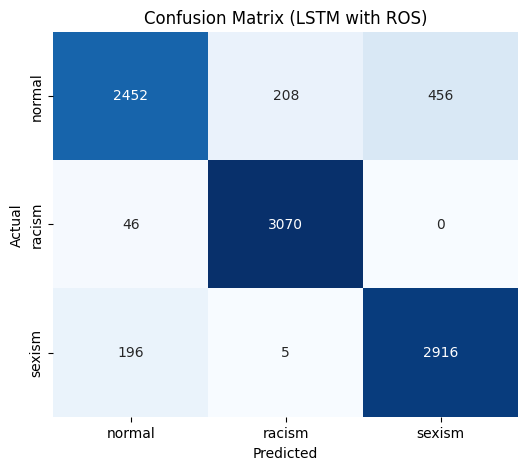

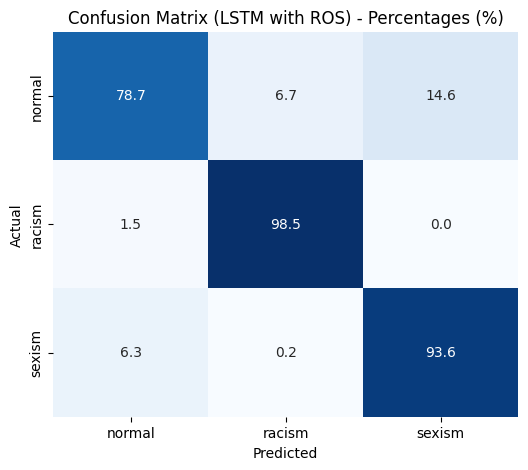


Classification report:
              precision    recall  f1-score   support

      normal       0.91      0.79      0.84      3116
      racism       0.94      0.99      0.96      3116
      sexism       0.86      0.94      0.90      3117

    accuracy                           0.90      9349
   macro avg       0.90      0.90      0.90      9349
weighted avg       0.90      0.90      0.90      9349

Accuracy : 0.9
Precision : 0.9
Recall : 0.9
F1-score : 0.9


In [18]:
evaluate_model(model_lstm_ros, X_test_ros, y_test_ros, model_name="LSTM with ROS")

## With GAN

In [ ]:
# dataset coming from after GAN augmentation concatenated with original dataset
df_gan = read_pickle('path/Dataset/GAN_Augmented_DF.pkl')

In [14]:
X_ros = df_gan['text'].tolist()
y_ros = df_gan['label'].values

In [ ]:
# encode labels
le = LabelEncoder()
y_enc = le.fit_transform(y_ros)
num_classes = len(le.classes_)

# tokenization
token = Tokenizer(num_words=None, oov_token="<OOV>")
token.fit_on_texts(X_ros)

sequences = token.texts_to_sequences(X_ros)
max_len = 40
padded_sequences = sequence.pad_sequences(sequences, maxlen=max_len)

# train-test split with GAN augmented data
X_train_gan, X_test_gan, y_train_gan, y_test_gan = train_test_split(padded_sequences, y_enc, test_size=0.3, stratify=y_ros, random_state=42)

word_index = token.word_index

# create embedding matrix
embedding_dim = 200
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|██████████| 15356/15356 [00:00<00:00, 497314.76it/s]


In [16]:
model_lstm_gan = simple_lstm_model(len(word_index) + 1, embedding_matrix, max_len)
model_lstm_gan.fit(X_train_gan, y_train_gan, epochs=5, batch_size=32)

Epoch 1/5
484/484 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.7387 - loss: 0.5990
Epoch 2/5
484/484 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.8514 - loss: 0.3763
Epoch 3/5
484/484 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.8734 - loss: 0.3233
Epoch 4/5
484/484 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.8848 - loss: 0.2912
Epoch 5/5
484/484 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.9021 - loss: 0.2456


208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step

--- Results for LSTM with GAN ---
Confusion matrix (raw values):


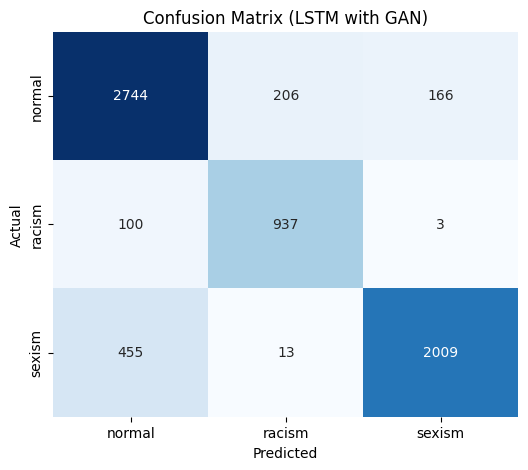

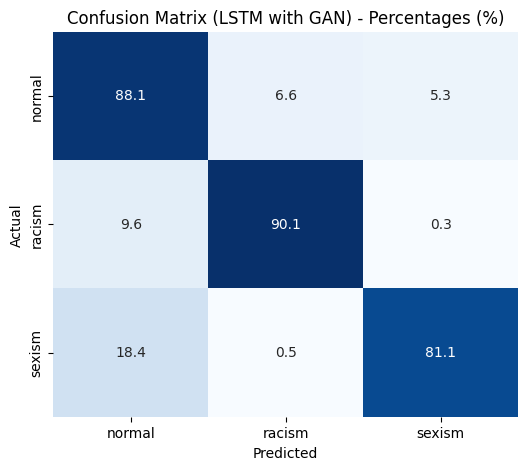


Classification report:
              precision    recall  f1-score   support

      normal       0.83      0.88      0.86      3116
      racism       0.81      0.90      0.85      1040
      sexism       0.92      0.81      0.86      2477

    accuracy                           0.86      6633
   macro avg       0.85      0.86      0.86      6633
weighted avg       0.86      0.86      0.86      6633

Accuracy : 0.86
Precision : 0.86
Recall : 0.86
F1-score : 0.86


In [17]:
evaluate_model(model_lstm_gan, X_test_gan, y_test_gan, model_name="LSTM with GAN")

### Without augmentation

In [ ]:
# encode labels
le = LabelEncoder()
y_enc = le.fit_transform(y)
num_classes = len(le.classes_)

# tokenization
token = Tokenizer(num_words=None, oov_token="<OOV>")
token.fit_on_texts(X)

sequences = token.texts_to_sequences(X)
max_len = 40
padded_sequences = sequence.pad_sequences(sequences, maxlen=max_len)

# train-test split with original data
X_train_no, X_test_no, y_train_no, y_test_no = train_test_split(padded_sequences, y_enc, test_size=0.3, stratify=y, random_state=42)

word_index = token.word_index

# create embedding matrix
embedding_dim = 200
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|██████████| 15356/15356 [00:00<00:00, 444157.56it/s]


In [20]:
model_lstm_no = simple_lstm_model(len(word_index) + 1, embedding_matrix, max_len)
model_lstm_no.fit(X_train_no, y_train_no, epochs=5, batch_size=32)

Epoch 1/5
342/342 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.7292 - loss: 0.6669
Epoch 2/5
342/342 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.8036 - loss: 0.4745
Epoch 3/5
342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.8145 - loss: 0.4430
Epoch 4/5
342/342 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.8311 - loss: 0.4129
Epoch 5/5
342/342 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.8536 - loss: 0.3644


147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step

--- Results for LSTM without augmentation ---
Confusion matrix (raw values):


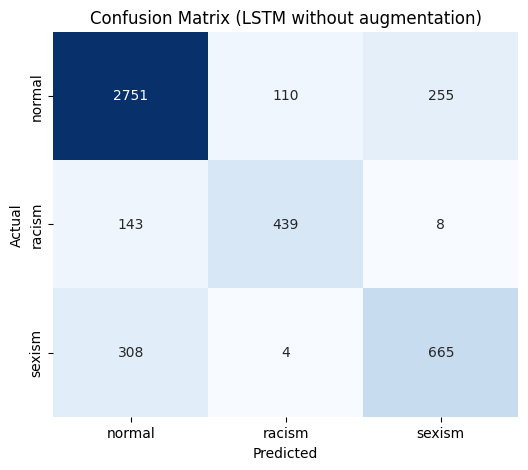

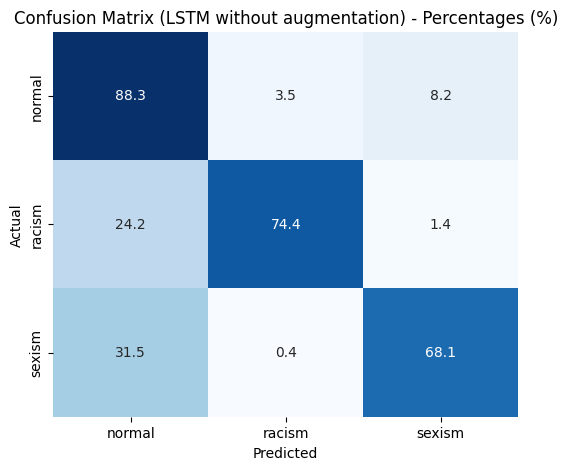


Classification report:
              precision    recall  f1-score   support

      normal       0.86      0.88      0.87      3116
      racism       0.79      0.74      0.77       590
      sexism       0.72      0.68      0.70       977

    accuracy                           0.82      4683
   macro avg       0.79      0.77      0.78      4683
weighted avg       0.82      0.82      0.82      4683

Accuracy : 0.82
Precision : 0.82
Recall : 0.82
F1-score : 0.82


In [21]:
evaluate_model(model_lstm_no, X_test_no, y_test_no, model_name="LSTM without augmentation")